In [1]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
def init_spin_lattice(size):
    """
    Returns a lattice size*size dimensions filled with an equal proportion of +- 1 as a numpy array.
    """
    return np.random.choice([-1,1], size=(size,size))

def init_grid(size):
    """
    Creates a meshgrid for use with init_spin_lattice for plotting snapshots of the lattice configuration.
    """
    return np.meshgrid(range(size), range(size))

In [3]:
def calculate_magnetization(lattice):
    """
    Calculates the magnetization of the lattice.
    """
    magnetization = 0
    size = len(lattice)
    magnetization = sum(lattice.flatten())/(size*size)
    return abs(magnetization)

In [4]:
def calculate_energies(lattice, J):
    """
    Calculates the energy of the system. J is the the exchange constant
    """
    energy = 0
    size = len(lattice)
    for row in range(size):
        for col in range(size):
            neighbour_sum = lattice[row, (col+1)%size] + lattice[row, (col-1)%size] \
                    + lattice[(row+1)%size, col] + lattice[(col-1)%size, col]
            energy += -J * lattice[row, col] * neighbour_sum
    return energy/(size*size)
    

In [5]:
def calculate_susceptibility(magnetizations, temperature, k):
    """
    Calculates the magnetic susceptibility from list of magnetizations of each lattice state.
    """
    mean_mag = np.mean(magnetizations) #mean of mags to square later for var calculation
    mean_mag_square = np.mean(np.square(magnetizations)) #mean of square
    susceptibility = (1 / (k * temperature)) * \
                        (mean_mag_square - np.abs(mean_mag)**2)
    return susceptibility

def calculate_specific_heat(energies, temperature, k):
    """
    Calculates the specific heat of the material based on energies of te lattice arrangements.
    """
    mean_energy = np.mean(energies)
    mean_energy_square = np.mean(np.square(energies))
    specific_heat = (1 / (k * temperature**2)) * \
                (mean_energy_square - mean_energy**2)
    return specific_heat

def metropolis_update(lattice, temperature, J, k):
    """
    lattice: square lattice filled with +-1 values representing spins
    temperature: temperature of the surrounding heatbath
    J: exchange constant, this is usually left as +1 
    k: Boltzmans constant, also left as 1 to ensure j/kb ratio stays consistent
    """
    size = len(lattice) #get size of lattice
    row, col = np.random.randint(size, size=2) #choose random spin
    spin = lattice[row, col] #get the random spin
    neighbour_sum = lattice[row, (col+1)%size] + lattice[row, (col-1)%size] \
                    + lattice[(row+1)%size, col] + lattice[(row-1)%size, col] #calculate nearest neighbor sum
    e_flip = 2 * J * spin * neighbour_sum #calculate energy if spin was flipped, e_flip
    #if negative or zero flip spin as would lower energy, or if  it would increase energy and a random number
    #is less than a probability of flip depending on temperature and energy
    if e_flip <= 0 or np.random.rand() < np.exp(-e_flip/(k * temperature)):
        lattice[row][col] = -spin        

In [6]:
def ising_simulation(size, temperature, eq_steps, sim_steps, J=1, k=1, record_eq=False):
    #this code runs a simulation of the ising model
    lattice = init_spin_lattice(size) #initisalize lattice
    lattice_snapshots = [] #initialize lists for recording values
    magnetizations = []
    energies = []
    
    if record_eq == False:
    
        for step in range(eq_steps): #these steps settle the simulation, like letting a something equal w temp
            metropolis_update(lattice, temperature, J, k) #hence the values are not recorded
        
        for step in range(sim_steps): #the simulation now runs, recording values
            metropolis_update(lattice, temperature, J, k)
            if step % 100 == 0: #every 100 steps record the magnetization, energy and record a snapshot of latt
                magnetizations.append(calculate_magnetization(lattice))
                energies.append(calculate_energies(lattice, J))
                lattice_snapshots.append(lattice.copy())
    else: #if record_eq is true, run for all n steps and record all values
        for step in range(eq_steps+sim_steps):
            metropolis_update(lattice, temperature, J, k)
            if step % 100 == 0:
                magnetizations.append(calculate_magnetization(lattice))
                energies.append(calculate_energies(lattice, J))
                lattice_snapshots.append(lattice.copy())
                
    return lattice_snapshots, magnetizations, energies

In [7]:
def change_simulation_temps(size, temps, eq_steps, sim_steps, j=1, k=1):
    # this function runs the ising simulation for a range of different temps then
    final_magnetizations = []
    final_energies = []
    susceptibilities = []
    specific_heats = []
    for temperature in tqdm(temps): #iterate over temps
        _, magnetizations, energies = ising_simulation(size, temperature, eq_steps, sim_steps, j, k)
        final_magnetizations.append(magnetizations[-1]) #append values
        final_energies.append(energies[-1])
        susceptibilities.append(calculate_susceptibility(magnetizations, temperature, k))
        specific_heats.append(calculate_specific_heat(energies, temperature, k))
    return final_magnetizations, final_energies, susceptibilities, specific_heats


In [21]:
def plot_info(size, final_magnetizations, final_energies, susceptibilities, specific_heats):
    fig, axs = plt.subplots(2,2, figsize=(12,8))
    
    fig.suptitle(f"{size}*{size} Lattice Grid")
    
    axs[0][0].plot(temps, final_energies, ".--", c="DarkRed", linewidth=0.8, markersize=4)
    axs[0][0].set_xlabel("Temperature (T)")
    axs[0][0].set_ylabel("Energy")
    
    axs[1][0].plot(temps, specific_heats, ".--", c="DarkRed", linewidth=0.8, markersize=4)
    axs[1][0].set_xlabel("Temperature (T)")
    axs[1][0].set_ylabel("Specific Heat")
    
    axs[0][1].plot(temps, final_magnetizations, ".--",  c="DarkGreen", linewidth=0.8, markersize=4)
    axs[0][1].set_xlabel("Temperature (T)")
    axs[0][1].set_ylabel("Magnetization")

    axs[1][1].plot(temps, susceptibilities, ".--",  c="DarkGreen", linewidth=0.8, markersize=4)
    axs[1][1].set_xlabel("Temperature (T)")
    axs[1][1].set_ylabel("Susceptibility")

In [ ]:
# Simulation parameters
temp = 2.5  # Temperature of the system

size = 8 # Size of the lattice
eq_steps = 2**15 # Number of Monte Carlo steps for equilization
sim_steps = 2**15 #number of steps for monte carlo to record
J = 1  # Interaction strength
k = 1



In [ ]:
# Run the simulation for one temp
lattice_snapshots, magnetizations, energies = ising_simulation(size, temp, eq_steps, sim_steps)

In [ ]:
plt.plot(range(0, sim_steps, 100), energies, "k")
plt.xlabel("Simulation Step")
plt.ylabel("Energy")
plt.show()

In [ ]:
plt.plot(range(0, sim_steps, 100), magnetizations, "k")
plt.xlabel("Simulation Step")
plt.ylabel("Magnetisation")
plt.show()

In [ ]:
grid = init_grid(size)

plt.pcolormesh(grid[0], grid[1], lattice_snapshots[1], cmap="cividis")

plt.axis('off')

plt.show()

### Simulation Size #1 - 8*8 Grid

In [14]:
size = 8 # Size of the lattice
stepsize= 0.16
temps = np.arange(stepsize, 5+stepsize, stepsize)

eq_steps = 2**15 # Number of Monte Carlo steps for equilization
sim_steps = 2**15 #number of steps for monte carlo to record


In [22]:
final_magnetizations, final_energies, susceptibilities, specific_heats = change_simulation_temps(size, temps, eq_steps, sim_steps)

100%|███████████████████████████████████████████| 32/32 [00:18<00:00,  1.70it/s]


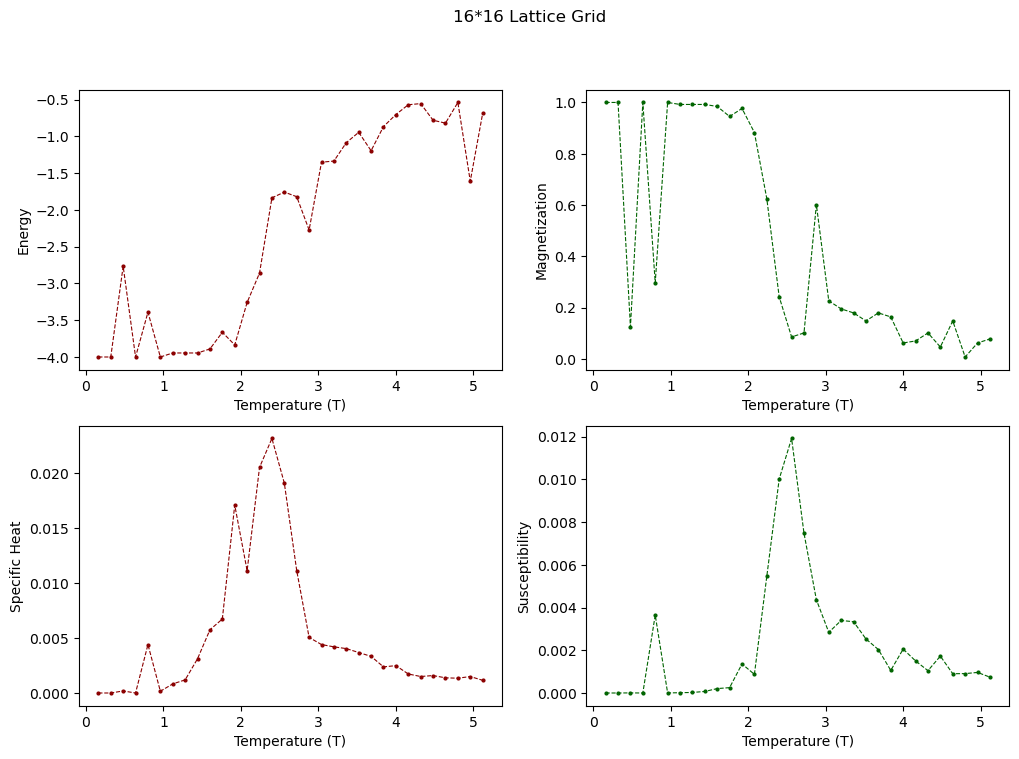

In [23]:
plot_info(size, final_magnetizations, final_energies, susceptibilities, specific_heats)

### Simulation Size #2 - 8*8 Grid

In [24]:
size = 16 # Size of the lattice
stepsize= 0.16
temps = np.arange(stepsize, 5+stepsize, stepsize)

eq_steps = 2**15 # Number of Monte Carlo steps for equilization
sim_steps = 2**15 #number of steps for monte carlo to record


In [25]:
final_magnetizations, final_energies, susceptibilities, specific_heats = change_simulation_temps(size, temps, eq_steps, sim_steps)

100%|███████████████████████████████████████████| 32/32 [00:19<00:00,  1.65it/s]


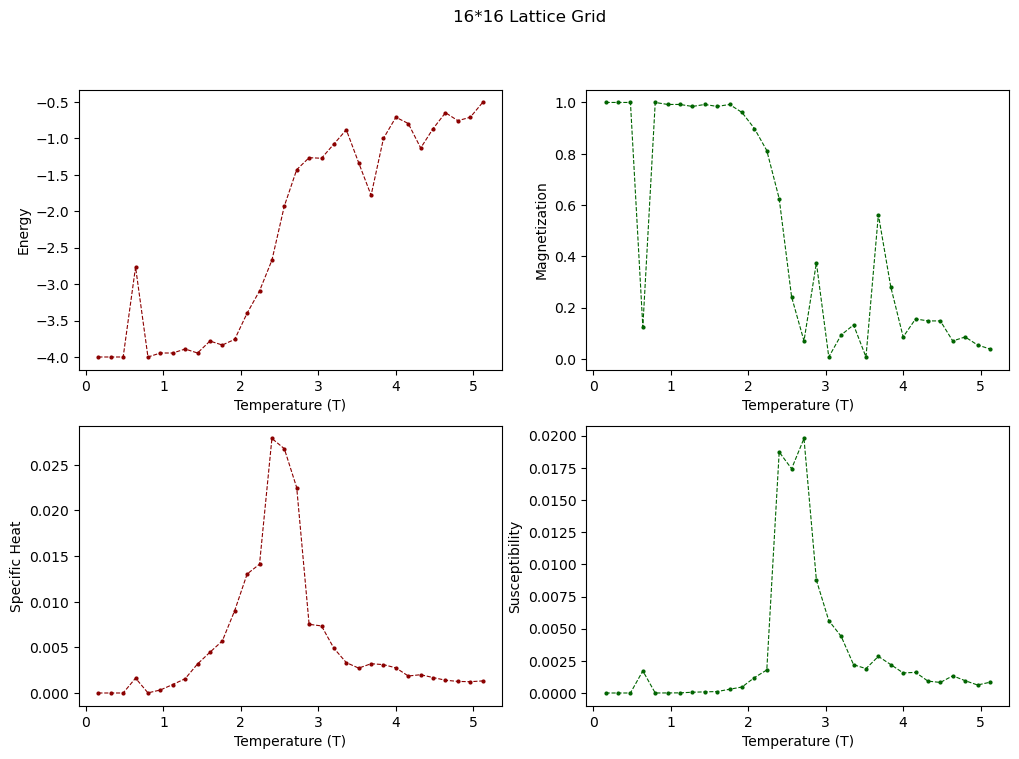

In [26]:
plot_info(size, final_magnetizations, final_energies, susceptibilities, specific_heats)

### Simulation Size #3 - 8*8 Grid

In [29]:
size = 32 # Size of the lattice
stepsize= 0.16
temps = np.arange(stepsize, 5+stepsize, stepsize)

eq_steps = 2**15 # Number of Monte Carlo steps for equilization
sim_steps = 2**15 #number of steps for monte carlo to record


In [ ]:
final_magnetizations, final_energies, susceptibilities, specific_heats = change_simulation_temps(size, temps, eq_steps, sim_steps)

 84%|████████████████████████████████████▎      | 27/32 [00:20<00:03,  1.36it/s]

In [ ]:
plot_info(size, final_magnetizations, final_energies, susceptibilities, specific_heats)

### Simulation Size #4 - 8*8 Grid

In [ ]:
size = 64 # Size of the lattice
stepsize= 0.16
temps = np.arange(stepsize, 5+stepsize, stepsize)

eq_steps = 2**15 # Number of Monte Carlo steps for equilization
sim_steps = 2**15 #number of steps for monte carlo to record


In [ ]:
final_magnetizations, final_energies, susceptibilities, specific_heats = change_simulation_temps(size, temps, eq_steps, sim_steps)

In [ ]:
plot_info(size, final_magnetizations, final_energies, susceptibilities, specific_heats)